<a href="https://colab.research.google.com/github/mdpw/msc-ai-cw/blob/main/cnn_model_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [7]:
file_path = "https://raw.githubusercontent.com/mdpw/msc-ai-cw/main/dataset/modified_cinnamon_quality_dataset.csv"
df = pd.read_csv(file_path)

# --- 1. Data Preparation ---
df = df.drop(columns=['Sample_ID'])
X = df.drop(columns=['Quality_Label'])
y = df['Quality_Label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_enc, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 0.8352, Train Acc: 0.7315 | Val Loss: 0.5846, Val Acc: 0.7778
Epoch 2/30 | Train Loss: 0.4815, Train Acc: 0.7844 | Val Loss: 0.3621, Val Acc: 0.8452
Epoch 3/30 | Train Loss: 0.3038, Train Acc: 0.9392 | Val Loss: 0.2165, Val Acc: 0.9722
Epoch 4/30 | Train Loss: 0.1835, Train Acc: 0.9854 | Val Loss: 0.1108, Val Acc: 0.9722
Epoch 5/30 | Train Loss: 0.1040, Train Acc: 0.9947 | Val Loss: 0.0651, Val Acc: 0.9722
Epoch 6/30 | Train Loss: 0.0620, Train Acc: 0.9934 | Val Loss: 0.0374, Val Acc: 1.0000
Epoch 7/30 | Train Loss: 0.0377, Train Acc: 0.9987 | Val Loss: 0.0228, Val Acc: 1.0000
Epoch 8/30 | Train Loss: 0.0321, Train Acc: 0.9960 | Val Loss: 0.0142, Val Acc: 1.0000
Epoch 9/30 | Train Loss: 0.0241, Train Acc: 0.9960 | Val Loss: 0.0139, Val Acc: 1.0000
Epoch 10/30 | Train Loss: 0.0147, Train Acc: 1.0000 | Val Loss: 0.0104, Val Acc: 1.0000
Epoch 11/30 | Train Loss: 0.0143, Train Acc: 0.9974 | Val Loss: 0.0065, Val Acc: 1.0000
Epoch 12/30 | Train Loss: 0.0119, Train A

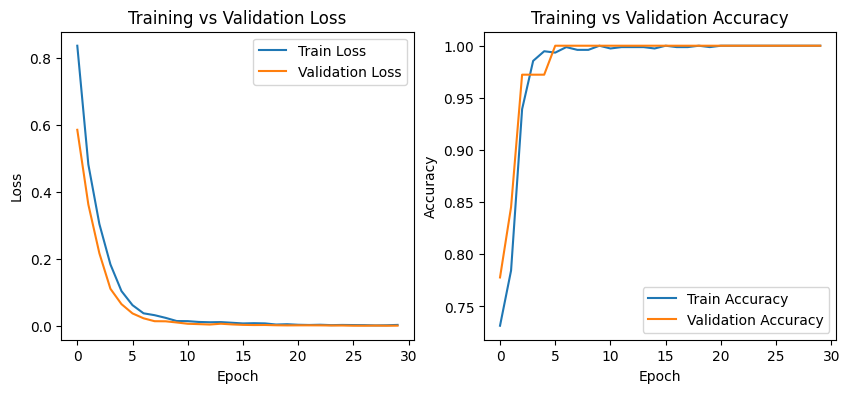

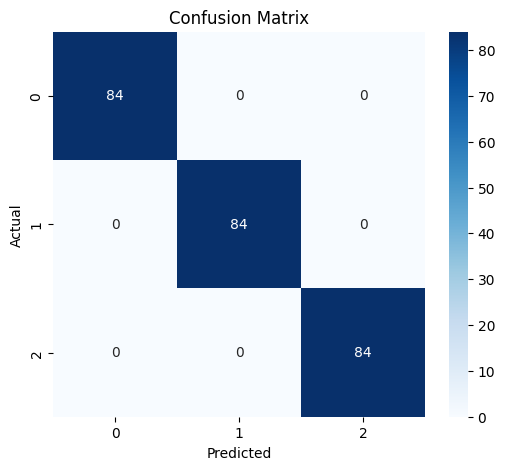

Classification Report:

              precision    recall  f1-score   support

        High       1.00      1.00      1.00        84
         Low       1.00      1.00      1.00        84
      Medium       1.00      1.00      1.00        84

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252

Overlap between train and test (data leakage check): False


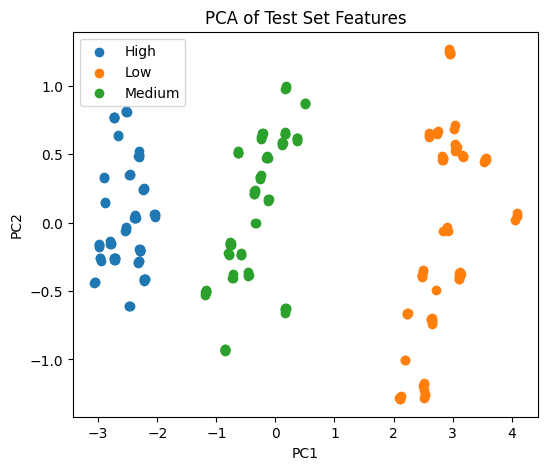

In [8]:
# --- 2. ANN Model with Dropout ---
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = len(le.classes_)

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = ANN()

# --- 3. Loss, Optimizer, Scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# --- 4. Training loop with Early Stopping and metric storage ---
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Scheduler step
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load("best_model.pth"))

# --- 5. Plot Loss & Accuracy curves ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# --- 6. Test Evaluation ---
y_test_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_test_pred.extend(predicted.tolist())

# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

# Data leakage check
train_rows = X_train_tensor.numpy()
test_rows = X_test_tensor.numpy()
overlap = np.any(np.all(np.isin(test_rows[:, None], train_rows), axis=2))
print("Overlap between train and test (data leakage check):", overlap)

# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)
plt.figure(figsize=(6,5))
for label in np.unique(y_test_enc):
    plt.scatter(X_pca[y_test_enc==label,0], X_pca[y_test_enc==label,1], label=le.classes_[label])
plt.legend()
plt.title("PCA of Test Set Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
